# Oct ??th, 2022 (vae play)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.vae import ConfigVAE, VAE
from utils.plotting import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from utils.process import setup_supervised_data
from analysis.sta import compute_sta
from analysis.hyperflow import *

from torch import nn
from torch.nn import functional as F

## AdaptiveAvgPool3d

In [20]:
pool = nn.AdaptiveAvgPool3d(1)
x = torch.randn((13, 64, 32, 32, 12))
x.shape

torch.Size([13, 64, 32, 32, 12])

In [21]:
y = pool(x)
y.shape

torch.Size([13, 64, 1, 1, 1])

## Interpolate

In [30]:
from sklearn.datasets import load_sample_image
flower = load_sample_image('flower.jpg').astype(float)

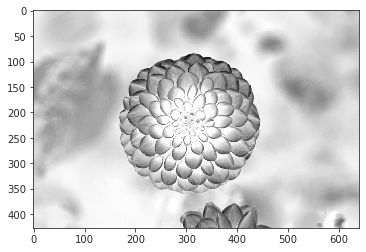

In [31]:
plt.imshow(flower[..., 2], cmap='Greys');

In [33]:
data = torch.tensor(flower[..., 2]).view(1, 1, 1, 427, 640)
up = F.interpolate(data, scale_factor=2, mode='nearest')
up.shape

torch.Size([1, 1, 2, 854, 1280])

In [34]:
up = up.detach().numpy().squeeze()
up.shape

(2, 854, 1280)

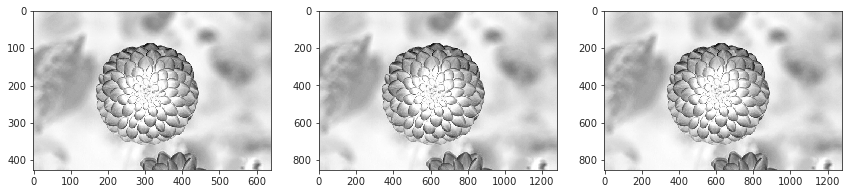

In [40]:
fig, axes = create_figure(1, 3, (14.5, 4))

axes[0].imshow(flower[..., 2], cmap='Greys')
axes[1].imshow(up[0], cmap='Greys')
axes[2].imshow(up[0], cmap='Greys')
plt.show()

## VAE

In [28]:
from model.common import Module, conv1x1x1, conv3x3x3, get_init_fn, add_sn, add_wn
from model.vae import RotConv3d, Cell, EncCombiner, DecCombiner

In [46]:
vae = VAE(ConfigVAE(n_groups_per_scale=4))

In [47]:
vae.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |   42.5 M   |
|     ---     |    ---     |
|     stem    |    248     |
|     pre     |   1.7 M    |
|     enc     |   25.0 M   |
|     enc0    |   65.8 K   |
|     dec     |   15.8 M   |
+-------------+------------+

In [49]:
vae.cfg.groups

[4, 2]

In [5]:
vae.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |   58.9 M   |
|     ---     |    ---     |
|     stem    |    248     |
|     pre     |   1.7 M    |
|     enc     |   57.2 M   |
+-------------+------------+

In [6]:
from utils.model import print_num_params
print_num_params(vae.enc)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  ModuleList |   57.2 M   |
|     ---     |    ---     |
|      0      |  887.7 K   |
|      1      |  887.7 K   |
|      2      |   16.5 K   |
|      3      |  887.7 K   |
|      4      |  887.7 K   |
|      5      |   16.5 K   |
|      6      |  887.7 K   |
|      7      |  887.7 K   |
|      8      |   16.5 K   |
|      9      |  887.7 K   |
|      10     |  887.7 K   |
|      11     |   16.5 K   |
|      12     |  887.7 K   |
|      13     |  887.7 K   |
|      14     |   16.5 K   |
|      15     |  887.7 K   |
|      16     |  887.7 K   |
|      17     |   16.5 K   |
|      18     |  887.7 K   |
|      19     |  887.7 K   |
|      20     |   16.5 K   |
|      21     |  887.7 K   |
|      22     |  887.7 K   |
|      23     |   16.5 K   |
|      24     |  887.7 K   |
|      25     |  887.7 K   |
|      26     |   16.5 K   |
|      27     |  887.7 K   |
|      28     |  887.7 K   |
|      29     |   16.5 K   |
|      30     |   3.5 M    |
|      31     |   3.5 M    |
|      32     |   3.5 M    |
|      33     |   65.8 K   |
|      34     |   3.5 M    |
|      35     |   3.5 M    |
|      36     |   65.8 K   |
|      37     |   3.5 M    |
|      38     |   3.5 M    |
|      39     |   65.8 K   |
|      40     |   3.5 M    |
|      41     |   3.5 M    |
|      42     |   65.8 K   |
|      43     |   3.5 M    |
|      44     |   3.5 M    |
+-------------+------------+

In [7]:
x = torch.randn((13, 2, 24, 16, 16))
x.shape

torch.Size([13, 2, 24, 16, 16])

In [8]:
y = vae.stem(x)
y.shape

torch.Size([13, 32, 24, 16, 16])

In [9]:
for op in vae.pre:
    y = op(y)
    print(y.shape)

torch.Size([13, 32, 24, 16, 16])

torch.Size([13, 32, 24, 16, 16])

torch.Size([13, 64, 12, 8, 8])

torch.Size([13, 64, 12, 8, 8])

torch.Size([13, 64, 12, 8, 8])

torch.Size([13, 128, 6, 4, 4])

In [10]:
y.shape

torch.Size([13, 128, 6, 4, 4])

In [17]:
vae.z0_sz

[20, 2, 2]